**Preparación: Descargando el conjunto de datos del Titanic**

El objetivo de este notebook es desarrollar un modelo que prediga quién sobrevivirá en el desastre del Titanic. Para hacer esto, empezaremos descargando el conjunto de datos del Titanic utilizando la API de Kaggle.

1. **Instalación de la API de Kaggle**:

    Primero, necesitamos instalar la biblioteca de la API de Kaggle. Esta biblioteca nos permitirá interactuar con Kaggle y descargar conjuntos de datos directamente en este notebook.

    Instala la biblioteca ejecutando la siguiente celda:
    ```python
    !pip install kaggle
    ```

    Puedes encontrar más detalles sobre cómo utilizar la API de Kaggle en su [documentación oficial](https://www.kaggle.com/docs/api).

2. **Descarga del conjunto de datos**:

    Con la biblioteca instalada, podemos proceder a descargar el conjunto de datos del Titanic. Ejecuta el siguiente comando en una celda:

    ```python
    !kaggle competitions download -c titanic
    ```

    Si deseas explorar más sobre este conjunto de datos, visita la [página de la competencia del Titanic en Kaggle](https://www.kaggle.com/competitions/titanic/data).


In [2]:
!pip install kaggle -q  #-q para no mostrar la salida

In [3]:
!mkdir /root/.kaggle/

mkdir: cannot create directory ‘/root/.kaggle/’: File exists


Descargamos el [kaggle.json](https://www.kaggle.com/settings)

In [4]:
!mv kaggle.json /root/.kaggle/

mv: cannot stat 'kaggle.json': No such file or directory


In [5]:
#Nos recomienda poner permisos de Lectura y Escritura al archivo .json para el propietario por seguridad.
!chmod 600 /root/.kaggle/kaggle.json

In [6]:
#Nos descargará un .zip
!kaggle competitions download -c titanic

titanic.zip: Skipping, found more recently modified local copy (use --force to force download)


In [7]:
#creamos una carpeta y descomprimimos dentro los archivos
!mkdir titanic
!unzip titanic.zip -d ./titanic

mkdir: cannot create directory ‘titanic’: File exists
Archive:  titanic.zip
replace ./titanic/gender_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [8]:
#Listamos los archivos descomprimidos.
!ls ./titanic

gender_submission.csv  test.csv  train.csv


En esta sección, utilizaremos herramientas como Pandas y NumPy para trabajar con nuestros datos.

In [9]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
import numpy as np
ds = pd.read_csv("./titanic/train.csv")

In [10]:
ds.info()  #Vemos que estamos manejando una cantidad muy pequena de datos, 418 filas y 11 columnas.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [11]:
ds.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

<Axes: xlabel='Pclass', ylabel='Fare'>

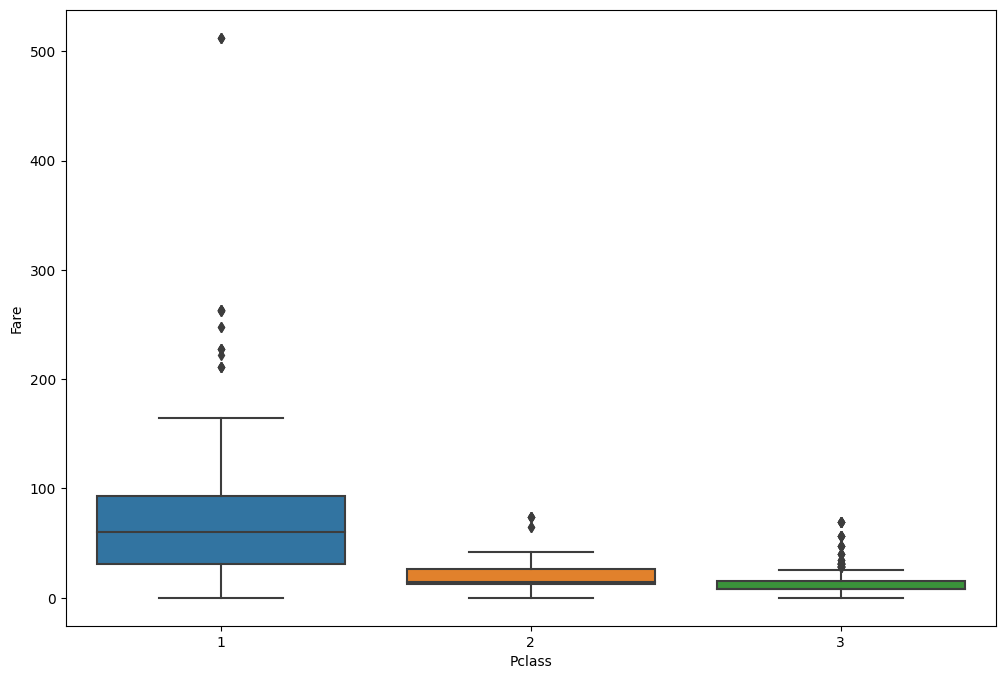

In [13]:
plt.figure(figsize = (12,8))
sns.boxplot(data = ds , x = 'Pclass', y = 'Fare')

Al observar los datos, vemos que tenemos un "PassengerID". Aunque estos datos pueden asignarse sin relación alguna con las variables predictivas, prestaremos atención a su poder predictivo. Sin embargo, partimos de la idea de descartarlo, ya que en su mayoría, los ID no representan ningún valor predictivo, a menos que contengan información implícita, como una correlación del número de ID a la clase. Como no contamos con esa información, asumiremos que no tiene información implícita y, por lo tanto, lo consideraremos como una variable con poco poder de predicción.

La "Pclass" nos indica la clase en la que se viaja, siendo 1 la más alta o de mayor poder adquisitivo, y 3 la más económica.

Tenemos los "Nombres". A primera vista, podemos considerarlos como variables categóricas y pensar en alguna forma de representarlos. Realizar una codificación one-hot (OHE) no es recomendable, pero quizá sí segmentar por género. Sin embargo, como ese dato ya está indicado en otra variable y algunos nombres tienen un título como "Mr.", podría ser útil segmentar los nombres según quién contiene ese título y quién no.

"sibsp": Número de hermanos/cónyuges a bordo del Titanic.

"Parch": Número de padres/hijos a bordo del Titanic.

"Ticket": Número de ticket.

"Fare": Tarifa del pasajero, es decir, lo que pagó por el boleto.

"Cabin": Número de cabina. Puede indicarnos en qué parte del barco se encontraban.

"Embarked": Puerto de embarque. C = Cherburgo, Q = Queenstown, S = Southampton. Representa el lugar donde el pasajero subió al barco. Podríamos pensar en el tiempo en el barco puede ser un factor de predicción.

## Aleatorización de Datos

Antes de comenzar el proceso de entrenamiento, es esencial **aleatorizar** o hacer un *shuffle* de nuestros datos.

### ¿Por qué es crucial aleatorizar los datos?

Cuando los datos están ordenados y no se mezclan adecuadamente, pueden surgir problemas al dividirlos para entrenamiento y validación. Imagina una situación en la que todos los ejemplos de una clase particular terminan en el conjunto de validación mientras que otra clase se concentra en el conjunto de entrenamiento. Esto contradice el principio de que nuestra división debería ser una muestra o división aleatoria.

Más información sobre la importancia de barajear los datos puede ser encontrada en esta [discusión de Data Science Stack Exchange](https://datascience.stackexchange.com/questions/24511/why-should-the-data-be-shuffled-for-machine-learning-tasks).

### Evitando la Fuga de Datos

Es fundamental dividir los datos antes de hacer cualquier transformación. Esta precaución nos ayuda a prevenir el **Data Leak**, un problema en el que la información del conjunto de prueba "se filtra" en el proceso de entrenamiento.

Puedes aprender más sobre cómo evitar la fuga de datos en este [artículo de Towards Data Science](https://towardsdatascience.com/avoid-data-leakage-split-your-data-before-processing-a7f172632b00).


In [14]:
ds.head(1)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.25,NaN,S


In [15]:
shuffled_df = ds.sample(frac=1).reset_index(drop=True)

In [16]:
shuffled_df.head(1)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,296,0,1,"Lewy, Mr. Ervin G",male,NaN,0,0,PC 17612,27.7208,NaN,C


Dividiendo los datos en Train, Validation  and Test.
Train es para ajustar los pesos y Validation para ir viendo el desempeno del modelo, sesgo, varianza, asi como para evitar sobreajuste, ajustar hiperparametros.

Test solo se ocupan una vez para la prueba final, simulando el proceso en produccion.

El conjunto test normalmente se ocupa una vez para una verificacion final, si algo sale mal en esto debes encontrar las causa, pero una principal es que el modelo se sobre-ajusto a los datos de entrenamieno y test, por reajustar iteradamente.

https://towardsdatascience.com/train-validation-and-test-sets-72cb40cba9e7

In [17]:
# from sklearn.model_selection import train_test_split
# X_train, X_test = train_test_split(shuffled_df, test_size=0.2, random_state=42)

In [18]:
def train_val(df:pd.DataFrame , f:float=0.10)->tuple([pd.DataFrame,pd.DataFrame]):
  test = df.sample(frac = f ,replace = False )
  train =   df[~df.index.isin(test.index)]
  return (train, test)
data_train, data_test = train_val(shuffled_df)

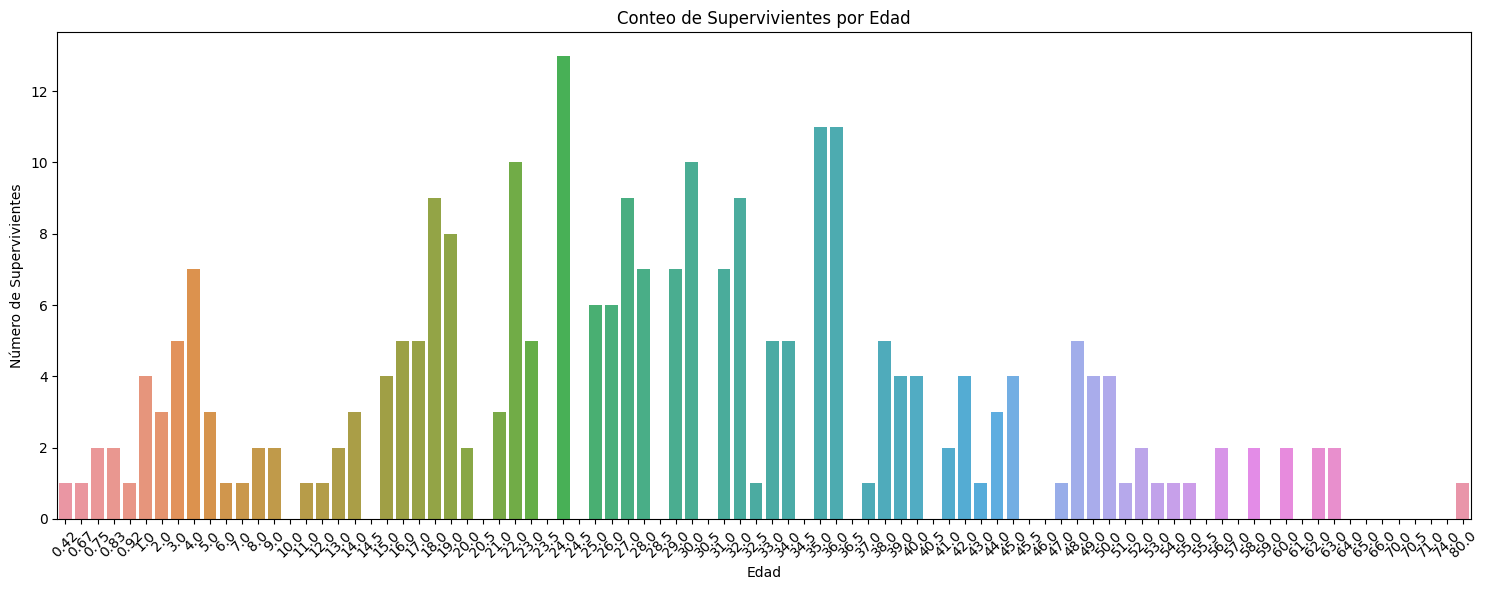

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
import re

# Agrupamos por Age y sumamos el número de supervivientes para cada edad
age_survived = data_train.groupby('Age')['Survived'].sum().reset_index()

# Usamos un barplot de Seaborn para visualizar
plt.figure(figsize=(15,6))
sns.barplot(x='Age', y='Survived', data=age_survived)
plt.title('Conteo de Supervivientes por Edad')
plt.xlabel('Edad')
plt.ylabel('Número de Supervivientes')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


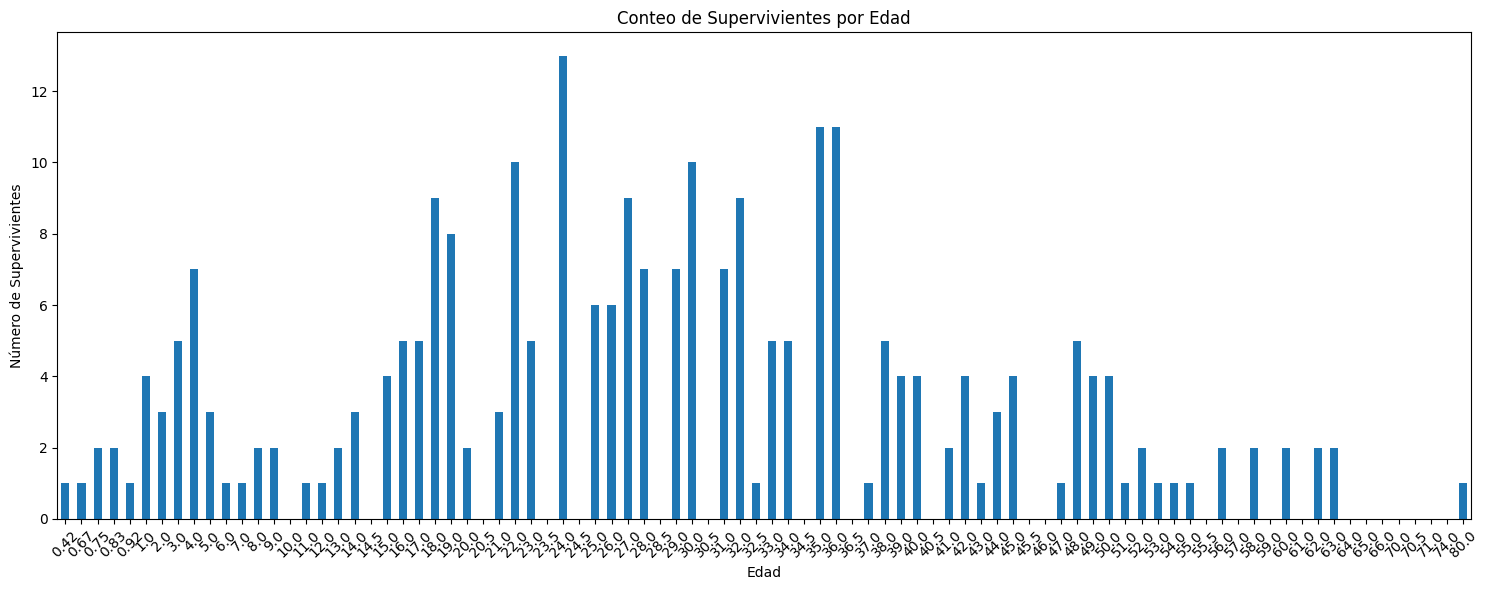

In [20]:
import matplotlib.pyplot as plt

# Agrupamos por Age y sumamos el número de supervivientes para cada edad
age_survived = data_train.groupby('Age')['Survived'].sum()

plt.figure(figsize=(15,6))
age_survived.plot(kind='bar')
plt.title('Conteo de Supervivientes por Edad')
plt.xlabel('Edad')
plt.ylabel('Número de Supervivientes')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


<ipython-input-21-779ebee46db5>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_train['AgeQuantile'], bins = pd.qcut(data_train['Age'], num_quantiles, labels=False, retbins=True)
<ipython-input-21-779ebee46db5>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_train['AgeQuantile'], bins = pd.qcut(data_train['Age'], num_quantiles, labels=False, retbins=True)
<ipython-input-21-779ebee46db5>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .l

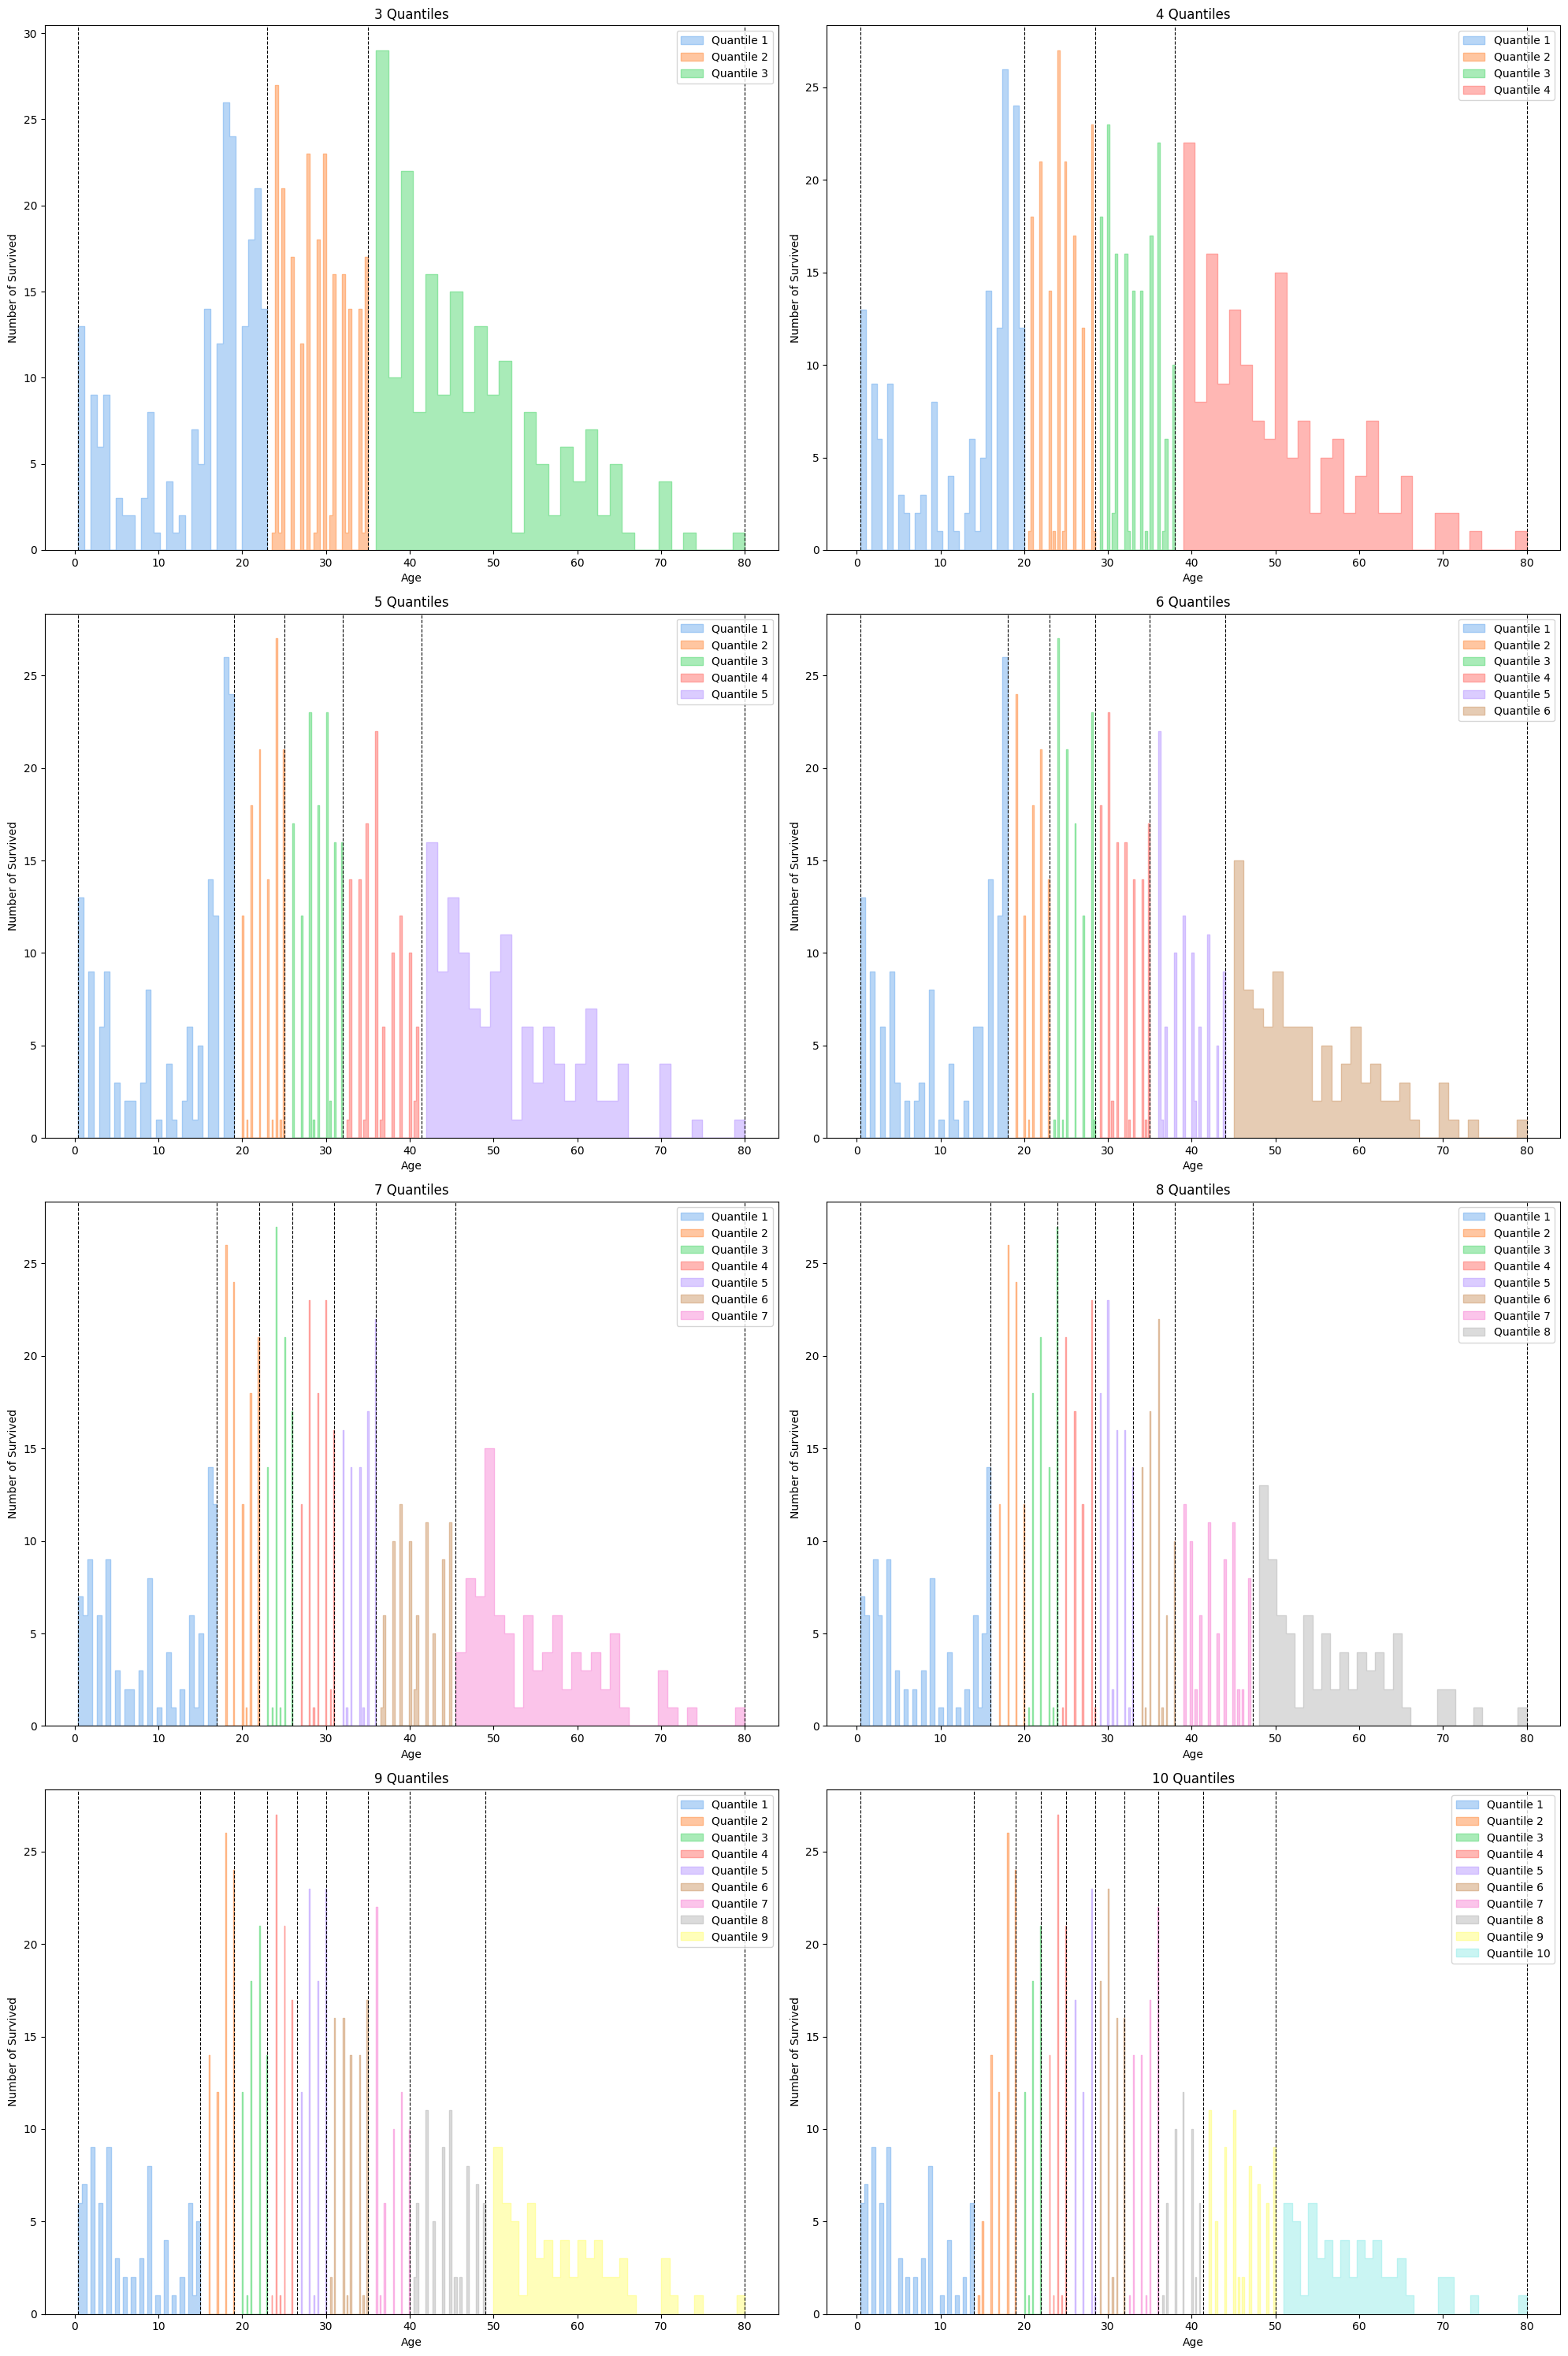

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Configuraciones iniciales
plt.figure(figsize=(20,30))

# Bucle para crear subplots para cada número de cuantiles (desde 3 hasta 10)
for i, num_quantiles in enumerate(range(3, 11)):
    # Crea cuantiles para la variable 'Age'
    data_train['AgeQuantile'], bins = pd.qcut(data_train['Age'], num_quantiles, labels=False, retbins=True)

    # Configura el subplot
    ax = plt.subplot(4, 2, i+1)

    # Dibuja los datos
    for q in range(num_quantiles):
        subset = data_train[data_train['AgeQuantile'] == q]
        sns.histplot(subset['Age'], kde=False, bins=30, color=sns.color_palette("pastel")[q], ax=ax, label=f'Quantile {q+1}', element="step")

    # Dibuja líneas verticales para los bordes de los cuantiles
    for b in bins:
        ax.axvline(b, color='black', linestyle='--', linewidth=0.8)

    ax.set_title(f'{num_quantiles} Quantiles')
    ax.set_xlabel('Age')
    ax.set_ylabel('Number of Survived')
    ax.legend()

plt.tight_layout()
plt.show()


Dado que los modelos usados en tensorflow tienen integrada la opcion de Validacion cruzada, no crearemos esa division de datos hasta ese momento.

Empezaremos con la fase de Limpieza de datos.

Usaremos una metodologia que consiste en revisar columna a columna una lista de limpieza comun a los datos.


* 1  : Repetibilidad en los datos. Existen Datos Repetidos.
* 2  : Inexistencia de datos. Hay datos faltantes, ¿Cómo se tratan?
* 3  : Error en los datos. Hay datos que no sean coherentes con los demás
* 4  : Errores de formato. ‘Espacios en blanco’ error en tipos de datos como char e int, formato de fechas,
* 5  :Verificar formato de fechas
* 6  :Verificar N/a
* 7  :Verificar espacios en blanco
* 8  :Verificar puntos decimal
* 9  :Verificar texto en formato número
* 10 :Verificar misma shape
* 11 :Verificar ortografía
* 12 :Verificar duplicados
* 13 :Verificar rango de datos
* 14 :Verificar números no estén en formato porcentaje o otro
* 15 :Verificar conversiones pesos dólares etc
* 16 :Verificar nombres no sean iguales en duplicados ej: mexico=mex=méxico
* 17 :Verificar en fechas horario de verano, invierno.




Dado que las mismas transformaciones las haremos al conjunto de test, el enfoque sera crear en funciones las transformaciones.

In [22]:
from sklearn.base import BaseEstimator, TransformerMixin
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
import re
from scipy import stats
import numpy as np

In [23]:
def identify_distribution(data):
    size = len(data)
    y, x = np.histogram(data, bins='auto', density=True)
    x = (x + np.roll(x, -1))[:-1] / 2.0

    # Prueba de Normalidad
    shapiro_test_stat, shapiro_p_value = stats.shapiro(data)
    if shapiro_p_value > 0.05:
        return 'normal'

    # Ajustar y probar otras distribuciones
    distributions = ['chi2', 't', 'gamma', 'expon', 'lognorm', 'weibull_min', 'weibull_max']
    for distribution in distributions:
        if distribution == 'chi2':
            params = stats.chi2.fit(data)
        elif distribution == 't':
            params = stats.t.fit(data)
        elif distribution == 'gamma':
            params = stats.gamma.fit(data)
        elif distribution == 'expon':
            params = stats.expon.fit(data)
        elif distribution == 'lognorm':
            params = stats.lognorm.fit(data)
        elif distribution == 'weibull_min':
            params = stats.weibull_min.fit(data)
        elif distribution == 'weibull_max':
            params = stats.weibull_max.fit(data)

        # Test de Kolmogorov-Smirnov
        d, p = stats.kstest(y, distribution, args=params)
        if p > 0.05:
            return distribution

    return 'unknown'

# Ejemplo
distribution = identify_distribution(data_train.loc[~data_train['Age'].isnull(),'Age'])
print(f"The data seems to follow a {distribution} distribution.")


The data seems to follow a unknown distribution.


In [24]:
class DataSetPreparation(BaseEstimator, TransformerMixin):
    def __init__(self):
        # Definimos las categorías para cada columna
        self.name_categories = ['BUCKET_MR', 'BUCKET_MISS', 'BUCKET_MRS', 'BUCKET_NONE']
        self.sex_categories = ['f', 'M', 'O']
        self.embarked_categories = ['s', 'c', 'q', 'o']
        self.cabin_level_categories = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'U']

        self.std_scaler = StandardScaler()
        self.minmax_scaler = MinMaxScaler()
        self.imputer = SimpleImputer(strategy='mean')
        self.imputer_2 = SimpleImputer(strategy='most_frequent')

        # Columns
        self.BINARY_FEATURES = ['Sex']
        self.NUMERIC_FEATURES = ['Age', 'Fare']
        self.CATEGORICAL_FEATURES = ['Pclass', 'Embarked','Parch', 'SibSp']

    def fit(self, X, y=None):
        X = X.copy()

        # Imputar valores faltantes para columnas excepto 'Age'
        for col in ['Pclass', 'SibSp', 'Parch', 'Fare']:
            X[col] = self.imputer.fit_transform(X[[col]])

        # Calcular media y desviación estándar (no sesgada) de la edad
        self.age_mean = X['Age'].mean()
        self.age_std = X['Age'].std(ddof=1)  # ddof=1 para desviación estándar no sesgada

        # Contar cuántos valores faltantes de edad hay
        missing_age_count = X['Age'].isnull().sum()

        # Generar una muestra aleatoria de edades basada en la media y desviación estándar
        age_sample = np.random.normal(self.age_mean, self.age_std, missing_age_count)

        # Rellenar valores faltantes de edad con la muestra generada
        age_series = X['Age'].copy()
        age_series[np.isnan(age_series)] = age_sample
        X['Age'] = age_series


        X["Embarked"] = self.imputer_2.fit_transform(X[["Embarked"]])

        # Ajustar el escalador de estandarización
        self.std_scaler.fit(X[['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']])
        # Transformar los datos con el escalador de estandarización y ajustar el escalador MinMax
        self.minmax_scaler.fit(X[['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']])

        self.ticket_frequencies = X['Ticket'].fillna("Unknown").value_counts()
        self.cabin_frequencies = X['Cabin'].value_counts()

        self.preprocessor = ColumnTransformer(
            transformers=[
                ('bin', OrdinalEncoder(), self.BINARY_FEATURES),
                ('num', StandardScaler(), self.NUMERIC_FEATURES),
                ('cat', OneHotEncoder(handle_unknown='ignore'), self.CATEGORICAL_FEATURES)
            ]
        )

        self.preprocessor.fit(X)

        return self

    def transform(self, X, y=None):
        # Borrar duplicados
        X = X.drop_duplicates().copy()
        missing_age_count = X['Age'].isnull().sum()
        age_sample = np.random.normal(self.age_mean, self.age_std, missing_age_count)
        age_series = X['Age'].copy()
        age_series[np.isnan(age_series)] = age_sample
        X['Age'] = age_series
        # Rellenar valores faltantes para las columnas numéricas con las medianas "aprendidas" durante el fit
        for col in ["Pclass", "Age", "SibSp", "Parch", "Fare"]:
            X[col].fillna(-1, inplace=True)
        X["Embarked"] = self.imputer_2.transform(X[["Embarked"]]).ravel() #ravel convierte 2d en 1d

        for col in ["Name", "Sex", "Ticket", "Cabin"]:
            X[col].fillna("Unknown", inplace=True)

##-----------------------VARIABLE CATEGORICAS AUN -------------------------------------------##
        X['NAME_BUCKET'] = X['Name'].apply(self.categorize_name)       #4 VALORES POSIBLES
        X['SEX_BUCKET']  = X['Sex'].apply(self.categorize_sex)         #3 VALORES POSIBLES
        X['EMBARKED']  = X['Embarked'].apply(self.categorize_embarked) #4 VALORES POSIBLES

        # FEATURE SINTETIC
        X['CABINLEVEL'] = X['Cabin'].str[0].fillna("Unknown")          #8 VALORES POSIBLES

###---------------------------------------------VARIABLES FLOAT -------------------------------------------------------------------##
        # Transformar usando estandarización y guardar en nuevas columnas
        X["AGE"] = X["Age"]
###----------------------------towards------------------
        data = [X]
        for dataset in data:
            dataset['relatives'] = dataset['SibSp'] + dataset['Parch']
            dataset.loc[dataset['relatives'] > 0, 'not_alone'] = 0
            dataset.loc[dataset['relatives'] == 0, 'not_alone'] = 1
            dataset['not_alone'] = dataset['not_alone'].astype(int)
        deck = {"A": 1, "B": 2, "C": 3, "D": 4, "E": 5, "F": 6, "G": 7, "U": 8}
        for dataset in data:
            dataset['CABIN'] = dataset['Cabin'].fillna("U0")
            dataset['Deck'] = dataset['CABIN'].map(lambda x: re.compile("([a-zA-Z]+)").search(x).group())
            dataset['Deck'] = dataset['Deck'].map(deck)
            dataset['Deck'] = dataset['Deck'].fillna(0)
            dataset['Deck'] = dataset['Deck'].astype(int)
        X = X.drop(['CABIN'], axis=1)
        for dataset in data:
            mean = self.age_mean
            std = self.age_std
            is_null = dataset["Age"].isnull().sum()
            # compute random numbers between the mean, std and is_null
            rand_age = np.random.randint(mean - std, mean + std, size=is_null)
            # fill NaN values in Age column with random values generated
            age_slice = dataset["Age"].copy()
            age_slice[np.isnan(age_slice)] = rand_age
            dataset["Age"] = age_slice
            dataset["AGE2"] = dataset["Age"].astype(int)
        common_value = 'S'
        for dataset in data:
            dataset['EMBARKED'] = dataset['Embarked'].fillna(common_value)
        for dataset in data:
            dataset['FARE'] = dataset['Fare'].fillna(0)
            dataset['FARE'] = dataset['FARE'].astype(int)
        titles = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
        for dataset in data:
            # extract titles
            dataset['TITLE'] = dataset.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
            # replace titles with a more common title or as Rare
            dataset['TITLE'] = dataset['TITLE'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr',\
                                                    'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
            dataset['TITLE'] = dataset['TITLE'].replace('Mlle', 'Miss')
            dataset['TITLE'] = dataset['TITLE'].replace('Ms', 'Miss')
            dataset['TITLE'] = dataset['TITLE'].replace('Mme', 'Mrs')
            # convert titles into numbers
            dataset['TITLE'] = dataset['TITLE'].map(titles)
            # filling NaN with 0, to get safe
            dataset['TITLE'] = dataset['TITLE'].fillna(0)
        genders = {"male": 0, "female": 1}
        for dataset in data:
            dataset['SEX'] = dataset['Sex'].map(genders)
        ports = {"S": 0, "C": 1, "Q": 2}
        for dataset in data:
            dataset['EMBARKED'] = dataset['EMBARKED'].map(ports)
        for dataset in data:
            dataset['AGE2'] = dataset['AGE2'].astype(int)
            dataset.loc[ dataset['AGE2'] <= 11, 'AGE2'] = 0
            dataset.loc[(dataset['AGE2'] > 11) & (dataset['AGE2'] <= 18), 'AGE2'] = 1
            dataset.loc[(dataset['AGE2'] > 18) & (dataset['AGE2'] <= 22), 'AGE2'] = 2
            dataset.loc[(dataset['AGE2'] > 22) & (dataset['AGE2'] <= 27), 'AGE2'] = 3
            dataset.loc[(dataset['AGE2'] > 27) & (dataset['AGE2'] <= 33), 'AGE2'] = 4
            dataset.loc[(dataset['AGE2'] > 33) & (dataset['AGE2'] <= 40), 'AGE2'] = 5
            dataset.loc[(dataset['AGE2'] > 40) & (dataset['AGE2'] <= 66), 'AGE2'] = 6
            dataset.loc[ dataset['AGE2'] > 66, 'AGE2'] = 6
        for dataset in data:
            dataset.loc[ dataset['FARE'] <= 7.91, 'FARE'] = 0
            dataset.loc[(dataset['FARE'] > 7.91) & (dataset['FARE'] <= 14.454), 'FARE'] = 1
            dataset.loc[(dataset['FARE'] > 14.454) & (dataset['FARE'] <= 31), 'FARE']   = 2
            dataset.loc[(dataset['FARE'] > 31) & (dataset['FARE'] <= 99), 'FARE']   = 3
            dataset.loc[(dataset['FARE'] > 99) & (dataset['FARE'] <= 250), 'FARE']   = 4
            dataset.loc[ dataset['FARE'] > 250, 'FARE'] = 5
            dataset['FARE'] = dataset['FARE'].astype(int)
        for dataset in data:
            dataset['Age_Class']= dataset['AGE2']* dataset['Pclass']
        for dataset in data:
            dataset['Fare_Per_Person'] = dataset['Fare']/(dataset['relatives']+1)
            dataset['Fare_Per_Person'] = dataset['Fare_Per_Person'].astype(int)
        # Crear columnas basadas en diferentes cuantiles
        for i in range(3, 16):  # Desde 3 hasta 15 cuantiles
            col_name = f"AGE_NoCuantiles_{i}"
            X[col_name] = self.assign_quantile(X, "Age", i)
        data_transformed = self.preprocessor.transform(X)
        df_transformed = pd.DataFrame(data_transformed)
        X = pd.concat([X.reset_index(drop=True), df_transformed.reset_index(drop=True)], axis=1)
        X.loc[:, ['Pclass_std', 'Age_std', 'SibSp_std', 'Parch_std', 'Fare_std']] = self.std_scaler.transform(X[['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']])
        # Transformar usando MinMaxScaler y guardar en otras nuevas columnas
        X.loc[:, ['Pclass_mm', 'Age_mm', 'SibSp_mm', 'Parch_mm', 'Fare_mm']] = self.minmax_scaler.transform(X[['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']])
    ##-------------------FEATURE ENGINEER A VARIABLES CATEGORICAS BRUTAS  -> FLOAT/INT---------------------------------------------------------#
        X['TICKET_BUCKET']  = X['Ticket'].apply(self.categorize_ticket)
        X['GROUPSIZE'] = X['Ticket'].map(self.ticket_frequencies).fillna(1)
        # Paso 2: Ajustar la columna "GROUPSIZE" con SibSp y Parch
        X['GROUPSIZE'] = X.apply(lambda row: max(row['GROUPSIZE'], row['SibSp'] + row['Parch'] + 1), axis=1)
        # Paso 3: Crear una columna "IsAlone"
        X['ISALONE'] = (X['GROUPSIZE'] == 1).astype(int)
        # FEATURE SINTETIC
        X['CABINGROUPSIZE'] = X['Cabin'].map(self.cabin_frequencies).fillna(-1)#4 VALORES POSIBLES
##-----------------------FEATURE ENGINEER A VARIABLES CATEGORICAS LIMPIADAS -> FLOAT-------------------------------------------##
        # Aplica la función custom_ohe a cada columna
        name_ohe = self.custom_ohe(X['NAME_BUCKET'], self.name_categories)
        sex_ohe = self.custom_ohe(X['SEX_BUCKET'], self.sex_categories)
        embarked_ohe = self.custom_ohe(X['EMBARKED'], self.embarked_categories)
        cabin_ohe = self.custom_ohe(X['CABINLEVEL'], self.cabin_level_categories)

        # Combina los DataFrames resultantes
        X.columns = X.columns.astype(str)
        ohe_result = pd.concat([name_ohe, sex_ohe, embarked_ohe, cabin_ohe], axis=1)
        X = pd.concat([X, ohe_result], axis=1)
        return X

    @staticmethod
    def categorize_name(name):
        name_lower = name.lower()
        if 'mr' in name_lower:
            return 'BUCKET_MR'
        elif 'miss' in name_lower or 'mlle' in name_lower or 'ms' in name_lower:
            return 'BUCKET_MISS'
        elif 'mrs' in name_lower or 'Mme' in name_lower:
            return 'BUCKET_MRS'
        else:
            return 'BUCKET_NONE'
    @staticmethod
    def categorize_sex(sex):
        sex_lower = sex.lower()
        if 'female' in sex_lower:
            return 'f'
        elif 'male' in sex_lower:
            return 'M'
        else:
            return 'O'
    def categorize_ticket(self, ticket):
        freq = self.ticket_frequencies.get(ticket, 0)
        return freq if 1 <= freq <= 7 else 0
    # Función para asignar cuantiles
    @staticmethod   #Los metodos estaticos no usan self
    def assign_quantile(df, column, n_quantiles):
        labels = list(range(1, n_quantiles + 1))
        return pd.qcut(df[column], q=n_quantiles, labels=labels).astype(int)
    @staticmethod
    def categorize_embarked(em):
        em_lower = em.lower()
        if 's' in em_lower:
            return 's'
        elif 'c' in em_lower:
            return 'c'
        elif 'q' in em_lower:
            return 'q'
        else:
            return 'o'
    def custom_ohe(self, column, categories):
        """Aplica One-Hot Encoding a la columna dadas las categorías especificadas."""
        # Crea un DataFrame con OHE
        ohe_df = pd.get_dummies(column, prefix_sep='_')

        # Crea un DataFrame vacío con las categorías deseadas
        custom_ohe_df = pd.DataFrame(0, index=ohe_df.index, columns=categories)

        # Llena el DataFrame personalizado con las columnas del OHE original
        for col in categories:
            if col in ohe_df.columns:
                custom_ohe_df[col] = ohe_df[col].values

        return custom_ohe_df
    def preprocess_data(self, df: pd.DataFrame) -> pd.DataFrame:
        # 1. Clean missing numerics
        for n in self.NUMERIC_FEATURES:
            df[n] = pd.to_numeric(df[n], errors='coerce')
        df = df.fillna(df.mean())

        # 2. Transformation Pipeline
        preprocessor = ColumnTransformer(
            transformers=[
                ('bin', OrdinalEncoder(), self.BINARY_FEATURES),
                ('num', StandardScaler(), self.NUMERIC_FEATURES),
                ('cat', OneHotEncoder(handle_unknown='ignore'), self.CATEGORICAL_FEATURES)
            ]
        )

        data_transformed = preprocessor.fit_transform(df)

        # Convert transformed data back to DataFrame for readability (optional)
        columns_transformed = (self.BINARY_FEATURES +
                              self.NUMERIC_FEATURES +
                              list(preprocessor.named_transformers_['cat'].get_feature_names_out(self.CATEGORICAL_FEATURES)))

        df_transformed = pd.DataFrame(data_transformed, columns=columns_transformed)

        return df_transformed

In [25]:
class feature_engineer(BaseEstimator, TransformerMixin):
    def fit(self, data_, y=None):
        # Obtener el índice de la columna "AGE"
        idx_age = data_.columns.get_loc("AGE")
        # Seleccionar todas las columnas desde "AGE" en adelante
        data = data_.iloc[:, idx_age:]
        data_without_missing_age = data[data['AGE'] != -1]
        data_for_clustering = data_without_missing_age.drop(columns=['Age_std', 'Age_mm'])

        data_for_clustering_all = data.drop(columns=['AGE','Age_std', 'Age_mm']) #Agregue esta linea con todos los datos para calcular al final
        data_for_clustering_all_2 = data.drop(columns=['Age_std', 'Age_mm']) #Agregue esta linea con todos los datos para calcular al final

        self.c1 = data_for_clustering_all.columns
        self.c2 = data_for_clustering_all_2.columns

        intervals = [(i, i+5) for i in range(0, 85, 5)]
        selected_centroids = []
        # 2. Seleccionar un dato aleatorio dentro de cada intervalo
        np.random.seed(42)
        for start, end in intervals:
            subset = data_without_missing_age[(data_without_missing_age['AGE'] >= start) & (data_without_missing_age['AGE'] < end)]
            if not subset.empty:
                sample = subset.sample(1).iloc[:,1:]
                selected_centroids.append(sample)
        # # 3. Concatenar todos los datos seleccionados
        initial_centroids_df = pd.concat(selected_centroids)
        # # Definiendo las características para clustering
        # Obtener todas las columnas de 'data'
        features_for_clustering = data.columns.tolist()
        # Excluir las columnas 'AGE', 'Age_std' y 'Age_mm'
        features_for_clustering = [column for column in features_for_clustering if column not in ['AGE', 'Age_std', 'Age_mm']]
        initial_centroids_values = initial_centroids_df[features_for_clustering].values
        # # Aplicar KMeans
        self.kmeans  = KMeans(n_clusters=len(initial_centroids_values), init=initial_centroids_values, n_init=1, random_state=42).fit(data_for_clustering.iloc[:,1:])
        self.kmeans_2 = KMeans(n_clusters=20, n_init=10, random_state=42).fit(data_for_clustering)
        self.kmeans_models = [KMeans(n_clusters=int(i+2), n_init=10, random_state=i).fit(data) for i in range(15)]

        return self

    def transform(self, data_):
        # Aquí pondrás todas las transformaciones adicionales que necesitas.
        idx_age = data_.columns.get_loc("AGE")
        # Seleccionar todas las columnas desde "AGE" en adelante
        data_a = data_.iloc[:, idx_age:]

        # Predecir los clusters
        cluster_assignments = self.kmeans.predict(data_[self.c1])
        cluster_assignments_2 = self.kmeans_2.predict(data_[self.c2])
        # Agregar las asignaciones de clusters como nuevas columnas
        data_['Cluster_1'] = cluster_assignments
        data_['Cluster_2'] = cluster_assignments_2

        for i, model in enumerate(self.kmeans_models):
          column_name = f'Cluster_{i+3}'
          data_[column_name] = model.predict(data_a)

        return data_

In [26]:
from sklearn.base import BaseEstimator, TransformerMixin
from joblib import dump, load
from google.cloud import storage
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from datetime import datetime
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import os

In [27]:
class PredictData(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.best_model = None
        self.columns_ = None
        os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "./key.json"

    def fit(self, data_, y=None):
        self.load_model()
        idx_age = data_.columns.get_loc("AGE")
        self.columns_ = data_.columns[idx_age:]
        # Seleccionar todas las columnas desde "AGE" en adelante
        x_train_, y_train_ = data_.iloc[:, idx_age:], data_.iloc[:, 1]
        if self.best_model is None:
            param_grid = {
                'n_estimators': [100,200,300],
                'max_depth': [20,40,80],
                'min_samples_split': [2,15,30],
                'min_samples_leaf': [1,5,50,100]
            }
            grid_search = GridSearchCV(RandomForestClassifier(), param_grid, cv=5, scoring='accuracy')
            grid_search.fit(x_train_, y_train_)
            self.best_model = grid_search.best_estimator_
        else:
            # Si ya hay un modelo cargado, ajusta el modelo al nuevo conjunto de datos
            self.best_model.fit(x_train_, y_train_)
        # Guarda el modelo entrenado localmente
        dump(self.best_model, 'model.joblib')
        # Sube el modelo entrenado a GCS
        try:
            self.save_model()
        except Exception as e:
            print(f"Error al subir el modelo entrenado a GCS: {str(e)}")
        return self

    def transform(self, data_):
      idx_age = data_.columns.get_loc("AGE")
      self.columns_ = data_.columns[idx_age:]
      # Seleccionar todas las columnas desde "AGE" en adelante
      x_train_ = data_.iloc[:,idx_age:]

      y_pred = self.best_model.predict(x_train_)
      return y_pred
    def save_model(self):
      current_date = datetime.now().strftime('%Y-%m-%d')
      current_hour = datetime.utcnow().strftime('%H:%M:%S')
      # Initialize the GCS client
      gcs_client = storage.Client()
      bucket_name = 'models_ai_save'
      # Construct the blob name using the date and hour
      blob_name = f'model/{current_date}/{current_hour}.joblib'
      # Upload the model to GCS
      bucket = gcs_client.get_bucket(bucket_name)
      blob = bucket.blob(blob_name)
      blob.upload_from_filename('model.joblib')
      print(f"Model uploaded to {blob_name} in GCS.")
    def load_model(self):
        gcs_client = storage.Client()
        bucket_name = 'models_ai_save'
        prefix = 'model/'
        try:
            bucket = gcs_client.get_bucket(bucket_name)
            blobs = list(bucket.list_blobs(prefix=prefix))
            # Descarga el modelo pre-entrenado si existe
            if blobs:
                # Sort blobs by date and then by hour
                sorted_blobs = sorted(blobs, key=lambda blob: blob.name, reverse=True)
                # Get the most recent blob
                recent_blob = sorted_blobs[0]
                # Download the most recent model
                file_name = 'recent_model.joblib'
                recent_blob.download_to_filename(file_name)
                self.best_model = load(file_name)
                print(f"Loaded model from {recent_blob.name}")
        except Exception as e:
            print(f"Error al cargar el modelo pre-entrenado: {str(e)}")

In [28]:
import joblib
def save_model():
  # Asumiendo que tu pipeline ya ha sido entrenado...
  joblib.dump(pipeline, 'pipe.pkl')
  current_date = datetime.now().strftime('%Y-%m-%d')
  current_hour = datetime.utcnow().strftime('%H:%M:%S')
  # Initialize the GCS client
  gcs_client = storage.Client()
  bucket_name = 'models_ai_save'
  # Construct the blob name using the date and hour
  blob_name = f'pipeline/{current_date}/{current_hour}.pkl'
  # Upload the model to GCS
  bucket = gcs_client.get_bucket(bucket_name)
  blob = bucket.blob(blob_name)
  blob.upload_from_filename('pipe.pkl')
  print(f"pipeline uploaded to {blob_name} in GCS.")
def load_model():
    gcs_client = storage.Client()
    bucket_name = 'models_ai_save'
    prefix = 'pipeline/'
    try:
        bucket = gcs_client.get_bucket(bucket_name)
        blobs = list(bucket.list_blobs(prefix=prefix))
        # Descarga el modelo pre-entrenado si existe
        if blobs:
            # Sort blobs by date and then by hour
            sorted_blobs = sorted(blobs, key=lambda blob: blob.name, reverse=True)
            # Get the most recent blob
            recent_blob = sorted_blobs[0]
            # Download the most recent model
            file_name = 'recent_pipe.pkl'
            recent_blob.download_to_filename(file_name)
            print(f"Loaded pipeline from {recent_blob.name}")
            return load(file_name)
        else: return None
    except Exception as e:
        print(f"Error al cargar el pipeline pre-entrenado: {str(e)}")
        return None

In [29]:
pipeline = Pipeline([
    ('data_preparation', DataSetPreparation()),
    ('feature_engineering', feature_engineer()),
    ('predict_data_train',PredictData()),
])
save_model()
pipeline2 = load_model()
# Usando el pipeline para transformar tus datos:
transformed_data_train = pipeline2.fit_transform(data_train)
transformed_data_test = pipeline2.transform(data_test)

pipeline uploaded to pipeline/2023-09-21/09:35:23.pkl in GCS.
Loaded pipeline from pipeline/2023-09-21/09:35:23.pkl
Loaded model from model/2023-09-21/09:24:12.joblib
Model uploaded to model/2023-09-21/09:35:32.joblib in GCS.


Desplegando el Modelo en un EndPoint

In [44]:
!mkdir -p endpoint  # El flag '-p' asegura que no se generará un error si el directorio ya existe


In [45]:
%%writefile endpoint/my_utilities.py

from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder,  MinMaxScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
import pandas as pd
import numpy as np
import re

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from google.cloud import storage
from joblib import dump, load
from datetime import datetime
import os


class DataSetPreparation(BaseEstimator, TransformerMixin):
    def __init__(self):
        # Definimos las categorías para cada columna
        self.name_categories = ['BUCKET_MR', 'BUCKET_MISS', 'BUCKET_MRS', 'BUCKET_NONE']
        self.sex_categories = ['f', 'M', 'O']
        self.embarked_categories = ['s', 'c', 'q', 'o']
        self.cabin_level_categories = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'U']

        self.std_scaler = StandardScaler()
        self.minmax_scaler = MinMaxScaler()
        self.imputer = SimpleImputer(strategy='mean')
        self.imputer_2 = SimpleImputer(strategy='most_frequent')

        # Columns
        self.BINARY_FEATURES = ['Sex']
        self.NUMERIC_FEATURES = ['Age', 'Fare']
        self.CATEGORICAL_FEATURES = ['Pclass', 'Embarked','Parch', 'SibSp']

    def fit(self, X, y=None):
        X = X.copy()

        # Imputar valores faltantes para columnas excepto 'Age'
        for col in ['Pclass', 'SibSp', 'Parch', 'Fare']:
            X[col] = self.imputer.fit_transform(X[[col]])

        # Calcular media y desviación estándar (no sesgada) de la edad
        self.age_mean = X['Age'].mean()
        self.age_std = X['Age'].std(ddof=1)  # ddof=1 para desviación estándar no sesgada

        # Contar cuántos valores faltantes de edad hay
        missing_age_count = X['Age'].isnull().sum()

        # Generar una muestra aleatoria de edades basada en la media y desviación estándar
        age_sample = np.random.normal(self.age_mean, self.age_std, missing_age_count)

        # Rellenar valores faltantes de edad con la muestra generada
        age_series = X['Age'].copy()
        age_series[np.isnan(age_series)] = age_sample
        X['Age'] = age_series


        X["Embarked"] = self.imputer_2.fit_transform(X[["Embarked"]])

        # Ajustar el escalador de estandarización
        self.std_scaler.fit(X[['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']])
        # Transformar los datos con el escalador de estandarización y ajustar el escalador MinMax
        self.minmax_scaler.fit(X[['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']])

        self.ticket_frequencies = X['Ticket'].fillna("Unknown").value_counts()
        self.cabin_frequencies = X['Cabin'].value_counts()

        self.preprocessor = ColumnTransformer(
            transformers=[
                ('bin', OrdinalEncoder(), self.BINARY_FEATURES),
                ('num', StandardScaler(), self.NUMERIC_FEATURES),
                ('cat', OneHotEncoder(handle_unknown='ignore'), self.CATEGORICAL_FEATURES)
            ]
        )

        self.preprocessor.fit(X)

        return self

    def transform(self, X, y=None):
        # Borrar duplicados
        X = X.drop_duplicates().copy()
        missing_age_count = X['Age'].isnull().sum()
        age_sample = np.random.normal(self.age_mean, self.age_std, missing_age_count)
        age_series = X['Age'].copy()
        age_series[np.isnan(age_series)] = age_sample
        X['Age'] = age_series
        # Rellenar valores faltantes para las columnas numéricas con las medianas "aprendidas" durante el fit
        for col in ["Pclass", "Age", "SibSp", "Parch", "Fare"]:
            X[col].fillna(-1, inplace=True)
        X["Embarked"] = self.imputer_2.transform(X[["Embarked"]]).ravel() #ravel convierte 2d en 1d

        for col in ["Name", "Sex", "Ticket", "Cabin"]:
            X[col].fillna("Unknown", inplace=True)

##-----------------------VARIABLE CATEGORICAS AUN -------------------------------------------##
        X['NAME_BUCKET'] = X['Name'].apply(self.categorize_name)       #4 VALORES POSIBLES
        X['SEX_BUCKET']  = X['Sex'].apply(self.categorize_sex)         #3 VALORES POSIBLES
        X['EMBARKED']  = X['Embarked'].apply(self.categorize_embarked) #4 VALORES POSIBLES

        # FEATURE SINTETIC
        X['CABINLEVEL'] = X['Cabin'].str[0].fillna("Unknown")          #8 VALORES POSIBLES

###---------------------------------------------VARIABLES FLOAT -------------------------------------------------------------------##
        # Transformar usando estandarización y guardar en nuevas columnas
        X["AGE"] = X["Age"]
###----------------------------towards------------------
        data = [X]
        for dataset in data:
            dataset['relatives'] = dataset['SibSp'] + dataset['Parch']
            dataset.loc[dataset['relatives'] > 0, 'not_alone'] = 0
            dataset.loc[dataset['relatives'] == 0, 'not_alone'] = 1
            dataset['not_alone'] = dataset['not_alone'].astype(int)
        deck = {"A": 1, "B": 2, "C": 3, "D": 4, "E": 5, "F": 6, "G": 7, "U": 8}
        for dataset in data:
            dataset['CABIN'] = dataset['Cabin'].fillna("U0")
            dataset['Deck'] = dataset['CABIN'].map(lambda x: re.compile("([a-zA-Z]+)").search(x).group())
            dataset['Deck'] = dataset['Deck'].map(deck)
            dataset['Deck'] = dataset['Deck'].fillna(0)
            dataset['Deck'] = dataset['Deck'].astype(int)
        X = X.drop(['CABIN'], axis=1)
        for dataset in data:
            mean = self.age_mean
            std = self.age_std
            is_null = dataset["Age"].isnull().sum()
            # compute random numbers between the mean, std and is_null
            rand_age = np.random.randint(mean - std, mean + std, size=is_null)
            # fill NaN values in Age column with random values generated
            age_slice = dataset["Age"].copy()
            age_slice[np.isnan(age_slice)] = rand_age
            dataset["Age"] = age_slice
            dataset["AGE2"] = dataset["Age"].astype(int)
        common_value = 'S'
        for dataset in data:
            dataset['EMBARKED'] = dataset['Embarked'].fillna(common_value)
        for dataset in data:
            dataset['FARE'] = dataset['Fare'].fillna(0)
            dataset['FARE'] = dataset['FARE'].astype(int)
        titles = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
        for dataset in data:
            # extract titles
            dataset['TITLE'] = dataset.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
            # replace titles with a more common title or as Rare
            dataset['TITLE'] = dataset['TITLE'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr',\
                                                    'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
            dataset['TITLE'] = dataset['TITLE'].replace('Mlle', 'Miss')
            dataset['TITLE'] = dataset['TITLE'].replace('Ms', 'Miss')
            dataset['TITLE'] = dataset['TITLE'].replace('Mme', 'Mrs')
            # convert titles into numbers
            dataset['TITLE'] = dataset['TITLE'].map(titles)
            # filling NaN with 0, to get safe
            dataset['TITLE'] = dataset['TITLE'].fillna(0)
        genders = {"male": 0, "female": 1}
        for dataset in data:
            dataset['SEX'] = dataset['Sex'].map(genders)
        ports = {"S": 0, "C": 1, "Q": 2}
        for dataset in data:
            dataset['EMBARKED'] = dataset['EMBARKED'].map(ports)
        for dataset in data:
            dataset['AGE2'] = dataset['AGE2'].astype(int)
            dataset.loc[ dataset['AGE2'] <= 11, 'AGE2'] = 0
            dataset.loc[(dataset['AGE2'] > 11) & (dataset['AGE2'] <= 18), 'AGE2'] = 1
            dataset.loc[(dataset['AGE2'] > 18) & (dataset['AGE2'] <= 22), 'AGE2'] = 2
            dataset.loc[(dataset['AGE2'] > 22) & (dataset['AGE2'] <= 27), 'AGE2'] = 3
            dataset.loc[(dataset['AGE2'] > 27) & (dataset['AGE2'] <= 33), 'AGE2'] = 4
            dataset.loc[(dataset['AGE2'] > 33) & (dataset['AGE2'] <= 40), 'AGE2'] = 5
            dataset.loc[(dataset['AGE2'] > 40) & (dataset['AGE2'] <= 66), 'AGE2'] = 6
            dataset.loc[ dataset['AGE2'] > 66, 'AGE2'] = 6
        for dataset in data:
            dataset.loc[ dataset['FARE'] <= 7.91, 'FARE'] = 0
            dataset.loc[(dataset['FARE'] > 7.91) & (dataset['FARE'] <= 14.454), 'FARE'] = 1
            dataset.loc[(dataset['FARE'] > 14.454) & (dataset['FARE'] <= 31), 'FARE']   = 2
            dataset.loc[(dataset['FARE'] > 31) & (dataset['FARE'] <= 99), 'FARE']   = 3
            dataset.loc[(dataset['FARE'] > 99) & (dataset['FARE'] <= 250), 'FARE']   = 4
            dataset.loc[ dataset['FARE'] > 250, 'FARE'] = 5
            dataset['FARE'] = dataset['FARE'].astype(int)
        for dataset in data:
            dataset['Age_Class']= dataset['AGE2']* dataset['Pclass']
        for dataset in data:
            dataset['Fare_Per_Person'] = dataset['Fare']/(dataset['relatives']+1)
            dataset['Fare_Per_Person'] = dataset['Fare_Per_Person'].astype(int)
        # Crear columnas basadas en diferentes cuantiles
        for i in range(3, 16):  # Desde 3 hasta 15 cuantiles
            col_name = f"AGE_NoCuantiles_{i}"
            X[col_name] = self.assign_quantile(X, "Age", i)
        data_transformed = self.preprocessor.transform(X)
        df_transformed = pd.DataFrame(data_transformed)
        X = pd.concat([X.reset_index(drop=True), df_transformed.reset_index(drop=True)], axis=1)
        X.loc[:, ['Pclass_std', 'Age_std', 'SibSp_std', 'Parch_std', 'Fare_std']] = self.std_scaler.transform(X[['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']])
        # Transformar usando MinMaxScaler y guardar en otras nuevas columnas
        X.loc[:, ['Pclass_mm', 'Age_mm', 'SibSp_mm', 'Parch_mm', 'Fare_mm']] = self.minmax_scaler.transform(X[['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']])
    ##-------------------FEATURE ENGINEER A VARIABLES CATEGORICAS BRUTAS  -> FLOAT/INT---------------------------------------------------------#
        X['TICKET_BUCKET']  = X['Ticket'].apply(self.categorize_ticket)
        X['GROUPSIZE'] = X['Ticket'].map(self.ticket_frequencies).fillna(1)
        # Paso 2: Ajustar la columna "GROUPSIZE" con SibSp y Parch
        X['GROUPSIZE'] = X.apply(lambda row: max(row['GROUPSIZE'], row['SibSp'] + row['Parch'] + 1), axis=1)
        # Paso 3: Crear una columna "IsAlone"
        X['ISALONE'] = (X['GROUPSIZE'] == 1).astype(int)
        # FEATURE SINTETIC
        X['CABINGROUPSIZE'] = X['Cabin'].map(self.cabin_frequencies).fillna(-1)#4 VALORES POSIBLES
##-----------------------FEATURE ENGINEER A VARIABLES CATEGORICAS LIMPIADAS -> FLOAT-------------------------------------------##
        # Aplica la función custom_ohe a cada columna
        name_ohe = self.custom_ohe(X['NAME_BUCKET'], self.name_categories)
        sex_ohe = self.custom_ohe(X['SEX_BUCKET'], self.sex_categories)
        embarked_ohe = self.custom_ohe(X['EMBARKED'], self.embarked_categories)
        cabin_ohe = self.custom_ohe(X['CABINLEVEL'], self.cabin_level_categories)

        # Combina los DataFrames resultantes
        X.columns = X.columns.astype(str)
        ohe_result = pd.concat([name_ohe, sex_ohe, embarked_ohe, cabin_ohe], axis=1)
        X = pd.concat([X, ohe_result], axis=1)
        return X

    @staticmethod
    def categorize_name(name):
        name_lower = name.lower()
        if 'mr' in name_lower:
            return 'BUCKET_MR'
        elif 'miss' in name_lower or 'mlle' in name_lower or 'ms' in name_lower:
            return 'BUCKET_MISS'
        elif 'mrs' in name_lower or 'Mme' in name_lower:
            return 'BUCKET_MRS'
        else:
            return 'BUCKET_NONE'
    @staticmethod
    def categorize_sex(sex):
        sex_lower = sex.lower()
        if 'female' in sex_lower:
            return 'f'
        elif 'male' in sex_lower:
            return 'M'
        else:
            return 'O'
    def categorize_ticket(self, ticket):
        freq = self.ticket_frequencies.get(ticket, 0)
        return freq if 1 <= freq <= 7 else 0
    # Función para asignar cuantiles
    @staticmethod   #Los metodos estaticos no usan self
    def assign_quantile(df, column, n_quantiles):
        labels = list(range(1, n_quantiles + 1))
        return pd.qcut(df[column], q=n_quantiles, labels=labels).astype(int)
    @staticmethod
    def categorize_embarked(em):
        em_lower = em.lower()
        if 's' in em_lower:
            return 's'
        elif 'c' in em_lower:
            return 'c'
        elif 'q' in em_lower:
            return 'q'
        else:
            return 'o'
    def custom_ohe(self, column, categories):
        """Aplica One-Hot Encoding a la columna dadas las categorías especificadas."""
        # Crea un DataFrame con OHE
        ohe_df = pd.get_dummies(column, prefix_sep='_')

        # Crea un DataFrame vacío con las categorías deseadas
        custom_ohe_df = pd.DataFrame(0, index=ohe_df.index, columns=categories)

        # Llena el DataFrame personalizado con las columnas del OHE original
        for col in categories:
            if col in ohe_df.columns:
                custom_ohe_df[col] = ohe_df[col].values

        return custom_ohe_df
    def preprocess_data(self, df: pd.DataFrame) -> pd.DataFrame:
        # 1. Clean missing numerics
        for n in self.NUMERIC_FEATURES:
            df[n] = pd.to_numeric(df[n], errors='coerce')
        df = df.fillna(df.mean())

        # 2. Transformation Pipeline
        preprocessor = ColumnTransformer(
            transformers=[
                ('bin', OrdinalEncoder(), self.BINARY_FEATURES),
                ('num', StandardScaler(), self.NUMERIC_FEATURES),
                ('cat', OneHotEncoder(handle_unknown='ignore'), self.CATEGORICAL_FEATURES)
            ]
        )

        data_transformed = preprocessor.fit_transform(df)

        # Convert transformed data back to DataFrame for readability (optional)
        columns_transformed = (self.BINARY_FEATURES +
                              self.NUMERIC_FEATURES +
                              list(preprocessor.named_transformers_['cat'].get_feature_names_out(self.CATEGORICAL_FEATURES)))

        df_transformed = pd.DataFrame(data_transformed, columns=columns_transformed)
        return df_transformed


class feature_engineer(BaseEstimator, TransformerMixin):
    def fit(self, data_, y=None):
        # Obtener el índice de la columna "AGE"
        idx_age = data_.columns.get_loc("AGE")
        # Seleccionar todas las columnas desde "AGE" en adelante
        data = data_.iloc[:, idx_age:]
        data_without_missing_age = data[data['AGE'] != -1]
        data_for_clustering = data_without_missing_age.drop(columns=['Age_std', 'Age_mm'])

        data_for_clustering_all = data.drop(columns=['AGE','Age_std', 'Age_mm']) #Agregue esta linea con todos los datos para calcular al final
        data_for_clustering_all_2 = data.drop(columns=['Age_std', 'Age_mm']) #Agregue esta linea con todos los datos para calcular al final

        self.c1 = data_for_clustering_all.columns
        self.c2 = data_for_clustering_all_2.columns

        intervals = [(i, i+5) for i in range(0, 85, 5)]
        selected_centroids = []
        # 2. Seleccionar un dato aleatorio dentro de cada intervalo
        np.random.seed(42)
        for start, end in intervals:
            subset = data_without_missing_age[(data_without_missing_age['AGE'] >= start) & (data_without_missing_age['AGE'] < end)]
            if not subset.empty:
                sample = subset.sample(1).iloc[:,1:]
                selected_centroids.append(sample)
        # # 3. Concatenar todos los datos seleccionados
        initial_centroids_df = pd.concat(selected_centroids)
        # # Definiendo las características para clustering
        # Obtener todas las columnas de 'data'
        features_for_clustering = data.columns.tolist()
        # Excluir las columnas 'AGE', 'Age_std' y 'Age_mm'
        features_for_clustering = [column for column in features_for_clustering if column not in ['AGE', 'Age_std', 'Age_mm']]
        initial_centroids_values = initial_centroids_df[features_for_clustering].values
        # # Aplicar KMeans
        self.kmeans  = KMeans(n_clusters=len(initial_centroids_values), init=initial_centroids_values, n_init=1, random_state=42).fit(data_for_clustering.iloc[:,1:])
        self.kmeans_2 = KMeans(n_clusters=20, n_init=10, random_state=42).fit(data_for_clustering)
        self.kmeans_models = [KMeans(n_clusters=int(i+2), n_init=10, random_state=i).fit(data) for i in range(15)]

        return self

    def transform(self, data_):
        # Aquí pondrás todas las transformaciones adicionales que necesitas.
        idx_age = data_.columns.get_loc("AGE")
        # Seleccionar todas las columnas desde "AGE" en adelante
        data_a = data_.iloc[:, idx_age:]

        # Predecir los clusters
        cluster_assignments = self.kmeans.predict(data_[self.c1])
        cluster_assignments_2 = self.kmeans_2.predict(data_[self.c2])
        # Agregar las asignaciones de clusters como nuevas columnas
        data_['Cluster_1'] = cluster_assignments
        data_['Cluster_2'] = cluster_assignments_2

        for i, model in enumerate(self.kmeans_models):
          column_name = f'Cluster_{i+3}'
          data_[column_name] = model.predict(data_a)

        return data_

class PredictData(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.best_model = None
        self.columns_ = None
        os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "./key.json"

    def fit(self, data_, y=None):
        self.load_model()
        idx_age = data_.columns.get_loc("AGE")
        self.columns_ = data_.columns[idx_age:]
        # Seleccionar todas las columnas desde "AGE" en adelante
        x_train_, y_train_ = data_.iloc[:, idx_age:], data_.iloc[:, 1]
        if self.best_model is None:
            param_grid = {
                'n_estimators': [100,200,300],
                'max_depth': [20,40,80],
                'min_samples_split': [2,15,30],
                'min_samples_leaf': [1,5,50,100]
            }
            grid_search = GridSearchCV(RandomForestClassifier(), param_grid, cv=5, scoring='accuracy')
            grid_search.fit(x_train_, y_train_)
            self.best_model = grid_search.best_estimator_
        else:
            # Si ya hay un modelo cargado, ajusta el modelo al nuevo conjunto de datos
            self.best_model.fit(x_train_, y_train_)
        # Guarda el modelo entrenado localmente
        dump(self.best_model, 'model.joblib')
        # Sube el modelo entrenado a GCS
        try:
            self.save_model()
        except Exception as e:
            print(f"Error al subir el modelo entrenado a GCS: {str(e)}")
        return self

    def transform(self, data_):
      idx_age = data_.columns.get_loc("AGE")
      self.columns_ = data_.columns[idx_age:]
      # Seleccionar todas las columnas desde "AGE" en adelante
      x_train_ = data_.iloc[:,idx_age:]

      y_pred = self.best_model.predict(x_train_)
      return y_pred
    def save_model(self):
      current_date = datetime.now().strftime('%Y-%m-%d')
      current_hour = datetime.utcnow().strftime('%H:%M:%S')
      # Initialize the GCS client
      gcs_client = storage.Client()
      bucket_name = 'models_ai_save'
      # Construct the blob name using the date and hour
      blob_name = f'model/{current_date}/{current_hour}.joblib'
      # Upload the model to GCS
      bucket = gcs_client.get_bucket(bucket_name)
      blob = bucket.blob(blob_name)
      blob.upload_from_filename('model.joblib')
      print(f"Model uploaded to {blob_name} in GCS.")
    def load_model(self):
        gcs_client = storage.Client()
        bucket_name = 'models_ai_save'
        prefix = 'model/'
        try:
            bucket = gcs_client.get_bucket(bucket_name)
            blobs = list(bucket.list_blobs(prefix=prefix))
            # Descarga el modelo pre-entrenado si existe
            if blobs:
                # Sort blobs by date and then by hour
                sorted_blobs = sorted(blobs, key=lambda blob: blob.name, reverse=True)
                # Get the most recent blob
                recent_blob = sorted_blobs[0]
                # Download the most recent model
                file_name = 'recent_model.joblib'
                recent_blob.download_to_filename(file_name)
                self.best_model = load(file_name)
                print(f"Loaded model from {recent_blob.name}")
        except Exception as e:
            print(f"Error al cargar el modelo pre-entrenado: {str(e)}")

def load_model():
    # os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "./key.json"
    gcs_client = storage.Client()
    bucket_name = 'models_ai_save'
    prefix = 'pipeline/'
    try:
        bucket = gcs_client.get_bucket(bucket_name)
        blobs = list(bucket.list_blobs(prefix=prefix))
        # Descarga el modelo pre-entrenado si existe
        if blobs:
            # Sort blobs by date and then by hour
            sorted_blobs = sorted(blobs, key=lambda blob: blob.name, reverse=True)
            # Get the most recent blob
            recent_blob = sorted_blobs[0]
            # Download the most recent model
            file_name = 'recent_pipe.pkl'
            recent_blob.download_to_filename(file_name)
            print(f"Loaded pipeline from {recent_blob.name}")
            return load(file_name)
        else: return None
    except Exception as e:
        print(f"Error al cargar el pipeline pre-entrenado: {str(e)}")
        return None

Writing endpoint/my_utilities.py


In [46]:
%%writefile endpoint/server.py

from my_utilities import DataSetPreparation, feature_engineer, PredictData, load_model
from flask import Flask, request, jsonify
import pandas as pd
import joblib

app = Flask(__name__)

# Carga el modelo al inicio
pipeline = load_model

@app.route('/predict', methods=['POST'])
def predict():
    data = request.get_json()
    df = pd.DataFrame(data['instances'])
    transformed_data = pipeline.transform(df)
    return jsonify(transformed_data.tolist())

if __name__ == '__main__':
    app.run(host='0.0.0.0', port=8080)



Writing endpoint/server.py


In [49]:
!pip freeze > endpoint/requirements.txt   #Dado que estamos en un notebook tendremos las dependecias configuradas en el notebook
#La mejor forma es ejecutar esto bajo un enviroment.
#Instala todas las dependencias del codigo y ejecuta.
#>python3 -m venv env
#>source env/bin/activate
#>pip freeze > requirements.txt

In [ ]:
%%writefile endpoint/DOCKERFILE
# Usa una imagen base de Python. Puedes ajustar la versión según tus necesidades.
FROM python:3.7-slim

# Establece un directorio de trabajo
WORKDIR /app

# Instala las dependencias necesarias
COPY requirements.txt /app/
RUN pip install --no-cache-dir -r requirements.txt

# Copia el código del modelo al contenedor
COPY server.py /app/

# Especifica el comando para ejecutar cuando el contenedor se inicie
CMD ["python", "/app/server.py"]


In [ ]:
%%writefile endpoint/dockerignore
__pycache__
*.pyc
*.pyo
*.egg-info


In [30]:
docker build -t my_model_image .

array([0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0,
       0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0,
       1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       0])

In [ ]:
gcloud auth configure-docker us-central1-docker.pkg.dev
docker tag my_model_image us-central1-docker.pkg.dev/projecto2-373519/myimages/my_model_image:latest
docker push us-central1-docker.pkg.dev/projecto2-373519/myimages/my_model_image:latest

In [ ]:
gcloud beta ai-platform versions create version1 \
  --model=modelo1 \
  --image=us-central1-docker.pkg.dev/projecto2-373519/myimages/my_model_image:latest \
  --region=us-central1  # Puedes necesitar especificar la región, dependiendo de la configuración

In [ ]:
import requests
import json

PROJECT = 'projecto2-373519'
MODEL_NAME = 'modelo1'
VERSION_NAME = 'version1'  # Omitir si no estás usando versiones específicas

# Construye la URL del endpoint
if VERSION_NAME:
    endpoint_url = f'https://ml.googleapis.com/v1/projects/{PROJECT}/models/{MODEL_NAME}/versions/{VERSION_NAME}:predict'
else:
    endpoint_url = f'https://ml.googleapis.com/v1/projects/{PROJECT}/models/{MODEL_NAME}:predict'

# Define tus datos de entrada
data = {
    "instances": [
        # Tus instancias aquí, por ejemplo:
        {"feature1": value1, "feature2": value2, ...},
        ...
    ]
}

# Hace la solicitud POST
headers = {"Authorization": f"Bearer {token}"}  # Asegúrate de tener un token de autenticación válido
response = requests.post(endpoint_url, json=data, headers=headers)

# Procesa la respuesta
predictions = response.json()["predictions"]

print(predictions)


In [31]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print(accuracy_score(data_test['Survived'],transformed_data_test)  )
print(precision_score(data_test['Survived'],transformed_data_test) )
print(recall_score(data_test['Survived'],transformed_data_test) )
print(f1_score(data_test['Survived'],transformed_data_test) )

0.8202247191011236
0.8518518518518519
0.6571428571428571
0.7419354838709677


In [33]:
ds_send = pd.read_csv("./titanic/test.csv")
transformed_data_send = pipeline2.transform(ds_send)

In [34]:
ds_send.head(1)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q


In [35]:
data_pred = pd.DataFrame(transformed_data_send,columns=["Survived"])
data_pred = pd.concat([ds_send["PassengerId"],data_pred],axis=1)
data_pred[["PassengerId","Survived"]].to_csv("All_clean.csv",index=False)

In [37]:
data_pred.head(1)

,PassengerId,Survived
0,892,0


In [40]:
random_forest = pipeline2.named_steps['predict_data_train'].best_model
col_  = pipeline2.named_steps['predict_data_train'].columns_

importances = pd.DataFrame({'feature':col_,'importance':np.round(random_forest.feature_importances_,3)})
importances = importances.sort_values('importance',ascending=False).set_index('feature')
importances.head(1)

,importance
feature,
0,0.118


In [41]:
importances.tail(1)

,importance
feature,
o,0.0


In [ ]:
%%bash
# Variables
MODEL_NAME="your_model_name" # Cambia a un nombre deseado para tu modelo
MODEL_VERSION="v1" # Puedes cambiar esto según lo necesites
PIPELINE_LOCATION="gs://pipeline/2023-09-21/09:23:54.pkl" # Ubicación de tu pipeline
REGION="us-central1" # Cambia según tu preferencia

# Crear el modelo en AI Platform
gcloud ai-platform models create ${MODEL_NAME} --regions ${REGION}

# Desplegar la versión del pipeline
gcloud ai-platform versions create ${MODEL_VERSION} \
    --model=${MODEL_NAME} \
    --origin=${PIPELINE_LOCATION} \
    --runtime-version=2.1 \
    --python-version=3.7


In [ ]:
from oauth2client.client import GoogleCredentials
import requests
import json

MODEL_NAME = "your_model_name"
MODEL_VERSION = "v1"
PROJECT = "your_project_id" # Asegúrate de especificar tu ID de proyecto de GCP

token = GoogleCredentials.get_application_default().get_access_token().access_token
api = "https://ml.googleapis.com/v1/projects/{}/models/{}/versions/{}:predict" \
         .format(PROJECT, MODEL_NAME, MODEL_VERSION)
headers = {"Authorization": "Bearer " + token }
data = {
  "instances": [
    # Tus instancias aquí
  ]
}
response = requests.post(api, json=data, headers=headers)
print(response.content)


In [1]:
pipeline2

NameError: ignored

In [ ]:
pipeline2

# FINISH HIM

In [ ]:
idx_age = transformed_data_train.columns.get_loc("AGE")
idx_age_ = transformed_data_test.columns.get_loc("AGE")
# Seleccionar todas las columnas desde "AGE" en adelante
x_train_, y_train_ = transformed_data_train.iloc[:,idx_age:],transformed_data_train.iloc[:,1]
x_test_,  y_test_  = transformed_data_test.iloc[:,idx_age_:],transformed_data_test.iloc[:,1]
x_train, x_test, y_train, y_test = x_train_, x_test_,  y_train_, y_test_

Empezamos a buscar el mejor modelo

In [ ]:
from sklearn.linear_model import LogisticRegression

# Inicializar y entrenar el modelo
logistic_model = LogisticRegression(max_iter=900)
logistic_model.fit(x_train_, y_train_)

# Hacer predicciones en el conjunto de test
y_pred_logistic = logistic_model.predict(x_test_)


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(RandomForestClassifier(), param_grid, cv=5, scoring='accuracy')
grid_search.fit(x_train, y_train)

best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

y_pred = best_model.predict(x_test)

# Evalúa el mejor modelo
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Mejores hiperparámetros:", best_params)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


Mejores hiperparámetros: {'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 200}
Accuracy: 0.8426966292134831
Precision: 0.7941176470588235
Recall: 0.7941176470588235
F1 Score: 0.7941176470588235


In [ ]:
from sklearn.tree import DecisionTreeClassifier

# Inicializar y entrenar el modelo
tree_model = DecisionTreeClassifier()
tree_model.fit(x_train_, y_train_)

# Hacer predicciones en el conjunto de test
y_pred_tree = tree_model.predict(x_test_)


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from tensorflow.keras.layers import Input, Dense, Add
from tensorflow.keras.models import Model


initial_learning_rate = 0.3
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=1000,   # Es el número de pasos en los que deseas reducir el learning rate
    decay_rate=0.003,    # Es la tasa de decaimiento
    staircase=True      # Si es True, la tasa de aprendizaje disminuye a intervalos discretos y, si es False, se reduce de manera continua.
)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

# Construir el modelo
input_data = Input(shape=(x_train_.shape[1],))
# Capa 1
x1 = Dense(38, activation='tanh')(input_data)
# Capa 2 con conexión residual desde la entrada
x2 = Dense(10, activation='elu')(x1)
x2 = Dense(10, activation='elu')(x2)
x2 = Dense(10, activation='elu')(x2)
residual_2 = Dense(10, activation='linear', use_bias=False)(input_data)  # Transformación de la dimensión
x2 = Add()([x2, residual_2])
# Capa 3 con conexión residual desde la entrada
x3 = Dense(48, activation='relu')(x2)
residual_3 = Dense(48, activation='linear', use_bias=False)(input_data)  # Transformación de la dimensión
x3 = Add()([x3, residual_3])
# Capa de salida

output = Dense(1, activation='sigmoid')(x3)
neural_model = Model(inputs=input_data, outputs=output)


# Métricas adicionales
metrics = [
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall'),
    tf.keras.metrics.AUC(name='auc')
]

# Compilar el modelo
neural_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=metrics)

# Callback para guardar el mejor modelo
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)


total = 432 + 281
weight_for_0 = total / (2 * 432)
weight_for_1 = total / (2 * 281)
class_weights = {0: weight_for_0, 1: weight_for_1}

# Entrenar el modelo
neural_model.fit(x_train_, y_train_, epochs=100, batch_size=8, validation_data=(x_test_, y_test_), callbacks=[checkpoint],class_weight=class_weights)



# Hacer predicciones en el conjunto de test
y_pred_neural = (neural_model.predict(x_test_) > 0.5).astype("int32")

# Calcula el F1-Score
f1 = f1_score(y_test_, y_pred_neural)
print(f"F1-Score: {f1}")

# Si deseas, puedes calcular las métricas adicionales de sklearn, como precisión, recall, AUC, etc., y mostrarlas.


Epoch 1/100
 95/101 [===========================>..] - ETA: 0s - loss: 149.3081 - accuracy: 0.5855 - precision: 0.4663 - recall: 0.5704 - auc: 0.5875
Epoch 1: val_accuracy improved from -inf to 0.69663, saving model to best_model.h5
101/101 [==============================] - 13s 10ms/step - loss: 141.6576 - accuracy: 0.5923 - precision: 0.4753 - recall: 0.5942 - auc: 0.5969 - val_loss: 9.5422 - val_accuracy: 0.6966 - val_precision: 0.8182 - val_recall: 0.2647 - val_auc: 0.6286
Epoch 2/100
 24/101 [======>.......................] - ETA: 0s - loss: 8.5241 - accuracy: 0.7135 - precision: 0.5652 - recall: 0.6094 - auc: 0.7148 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


 98/101 [============================>.] - ETA: 0s - loss: 6.7205 - accuracy: 0.6964 - precision: 0.5935 - recall: 0.6645 - auc: 0.7217
Epoch 2: val_accuracy improved from 0.69663 to 0.77528, saving model to best_model.h5
101/101 [==============================] - 1s 6ms/step - loss: 6.6446 - accuracy: 0.6920 - precision: 0.5864 - recall: 0.6721 - auc: 0.7210 - val_loss: 1.1277 - val_accuracy: 0.7753 - val_precision: 0.6842 - val_recall: 0.7647 - val_auc: 0.8447
Epoch 3/100
 95/101 [===========================>..] - ETA: 0s - loss: 6.7786 - accuracy: 0.6763 - precision: 0.5642 - recall: 0.6540 - auc: 0.6963
Epoch 3: val_accuracy improved from 0.77528 to 0.85393, saving model to best_model.h5
101/101 [==============================] - 1s 6ms/step - loss: 6.9541 - accuracy: 0.6796 - precision: 0.5710 - recall: 0.6656 - auc: 0.7017 - val_loss: 6.9162 - val_accuracy: 0.8539 - val_precision: 0.8889 - val_recall: 0.7059 - val_auc: 0.8249
Epoch 4/100
 93/101 [==========================>...] -

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

# Definir el modelo base (un árbol de decisión)
base_model = DecisionTreeClassifier(max_depth=100)

# Crear el modelo AdaBoost
ada_model = AdaBoostClassifier(estimator=base_model, n_estimators=100)

# Entrenar el modelo
ada_model.fit(x_train_, y_train_)

# Hacer predicciones
y_pred_adaboost = ada_model.predict(x_test_)


In [ ]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import VotingClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

# Preprocesamiento
scaler = StandardScaler()
x_train_scaled = x_train_
x_test_scaled = x_test_

# Crear varios modelos con hiperparámetros iniciales
log_clf = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000, C=0.1, solver='lbfgs'))
svm_clf = make_pipeline(StandardScaler(), SVC(probability=True, C=0.1, kernel='rbf', gamma='scale'))
xgb_clf = xgb.XGBClassifier(n_estimators=50, learning_rate=0.3, max_depth=5)
rf_clf = RandomForestClassifier(n_estimators=50, max_depth=None, min_samples_split=25)
dt_clf = DecisionTreeClassifier(max_depth=None, min_samples_split=15)

# Ensemble de votación
voting_clf = VotingClassifier(estimators=[
    ('lr', log_clf),
    ('svm', svm_clf),
    ('xgb', xgb_clf),
    ('rf', rf_clf),
    ('dt', dt_clf)
], voting='soft')  # soft voting

# Entrenamiento del ensemble
voting_clf.fit(x_train_scaled, y_train_)

# Predicciones
y_pred_voting = voting_clf.predict(x_test_scaled)

# Métrica

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Precisión
precision_logistic = precision_score(y_test_, y_pred_logistic)
precision_tree = precision_score(y_test_, y_pred_tree)
precision_neural = precision_score(y_test_, y_pred_neural)
precision_adaboost = precision_score(y_test_, y_pred_adaboost)

# Recall
recall_logistic = recall_score(y_test_, y_pred_logistic)
recall_tree = recall_score(y_test_, y_pred_tree)
recall_neural = recall_score(y_test_, y_pred_neural)
recall_adaboost = recall_score(y_test_, y_pred_adaboost)

# F1-Score
f1_logistic = f1_score(y_test_, y_pred_logistic)
f1_tree = f1_score(y_test_, y_pred_tree)
f1_neural = f1_score(y_test_, y_pred_neural)
f1_adaboost = f1_score(y_test_, y_pred_adaboost)

print("Accuracy LOG:", accuracy_score(y_test_, y_pred_logistic))
print("Precision de la Regresión Logística:", precision_logistic)
print("Recall de la Regresión Logística:", recall_logistic)
print("F1-score de la Regresión Logística:", f1_logistic)
print("\n")
print("Precision del Árbol de Decisión:", precision_tree)
print("Recall del Árbol de Decisión:", recall_tree)
print("F1-score del Árbol de Decisión:", f1_tree)
print("\n")
print("Precision de la Red Neuronal:", precision_neural)
print("Recall de la Red Neuronal:", recall_neural)
print("F1-score de la Red Neuronal:", f1_neural)
print("\n")
print("Precision de AdaBoost:", precision_adaboost)
print("Recall de AdaBoost:", recall_adaboost)
print("F1-score de AdaBoost:", f1_adaboost)
print("\n")
print("Precision voting:", precision_score(y_test_, y_pred_voting))
print("Recall voting:", recall_score(y_test_, y_pred_voting))
print("F1 Score voting:", f1_score(y_test_, y_pred_voting))


Accuracy LOG: 0.797752808988764
Precision de la Regresión Logística: 0.7105263157894737
Recall de la Regresión Logística: 0.7941176470588235
F1-score de la Regresión Logística: 0.7499999999999999


Precision del Árbol de Decisión: 0.6756756756756757
Recall del Árbol de Decisión: 0.7352941176470589
F1-score del Árbol de Decisión: 0.7042253521126761


Precision de la Red Neuronal: 0.5957446808510638
Recall de la Red Neuronal: 0.8235294117647058
F1-score de la Red Neuronal: 0.691358024691358


Precision de AdaBoost: 0.6857142857142857
Recall de AdaBoost: 0.7058823529411765
F1-score de AdaBoost: 0.6956521739130436


Precision voting: 0.8181818181818182
Recall voting: 0.7941176470588235
F1 Score voting: 0.8059701492537314


In [ ]:
fem = pd.read_csv("./titanic/gender_submission.csv")
#Score: 0.76555

In [ ]:
print("\n")
print("Accuracy voting:", accuracy_score(y_test_, y_pred_voting))
print("Precision voting:", precision_score(y_test_, y_pred_voting))
print("Recall voting:", recall_score(y_test_, y_pred_voting))
print("F1 Score voting:", f1_score(y_test_, y_pred_voting))



Accuracy voting: 0.8539325842696629
Precision voting: 0.8181818181818182
Recall voting: 0.7941176470588235
F1 Score voting: 0.8059701492537314


In [ ]:
y_pred_voting = voting_clf.predict(x_test_scaled)
f1_score(y_test_, y_pred_voting)

0.8059701492537314

In [ ]:
ds_send = pd.read_csv("./titanic/test.csv")
ds_send.head(1)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q


In [ ]:
d_t_clean = pipeline.transform(ds_send)
d_t_clean.iloc[:1,15:]

,AGE,AGE_NoCuantiles_3,AGE_NoCuantiles_4,AGE_NoCuantiles_5,AGE_NoCuantiles_6,AGE_NoCuantiles_7,AGE_NoCuantiles_8,AGE_NoCuantiles_9,AGE_NoCuantiles_10,AGE_NoCuantiles_11,...,Cluster_8,Cluster_9,Cluster_10,Cluster_11,Cluster_12,Cluster_13,Cluster_14,Cluster_15,Cluster_16,Cluster_17
0,34.5,2,3,4,4,5,6,6,7,8,...,5,6,1,2,6,6,4,8,1,5


In [ ]:
x__ = d_t_clean.iloc[:,15:]

Dado que el modelo logistico fue el que tuvo mayor

In [ ]:
y0 = logistic_model.predict(x__)
y1 = tree_model.predict(x__)
y2 = neural_model.predict(x__).reshape(-1,)
y3 = ada_model.predict(x__)
y4 = voting_clf.predict(x__)
y5 = best_model.predict(x__)

f1_logistic = f1_score(y_test_, y_pred_logistic)
f1_tree = f1_score(y_test_, y_pred_tree)
f1_neural = f1_score(y_test_, y_pred_neural)
f1_adaboost = f1_score(y_test_, y_pred_adaboost)
f1_voting_clf = f1_score(y_test_, y_pred_voting)

# Calcular la predicción final ponderada
y_final = (f1_logistic * y0 + f1_tree * y1 + f1_neural * y2 + f1_adaboost * y3 + f1_voting_clf * y4) / (f1_logistic + f1_tree + f1_neural + f1_adaboost + f1_voting_clf)

# Convertir la predicción final a valores binarios
y_final_binary = np.round(y_final).astype(int)


14/14 [==============================] - 0s 2ms/step


In [ ]:
data_pred = pd.DataFrame(y5,columns=["Survived"])
data_pred = pd.concat([d_t_clean["PassengerId"],data_pred],axis=1)

In [ ]:
data_pred[["PassengerId","Survived"]].to_csv("RandFor.csv",index=False)
#Obtuvimos un Score: 0.77511
#Intentaremos mejorar esa puntuacion con ingenieria de funciones despues.

Despliegue del modelo, usaremos 2 formas, una es cargar los pesos del modelo y descargarlos remotamente y subirlo a un endpoint.

In [ ]:
from joblib import dump, load
dump(logistic_model, 'logistic_model.joblib')

['logistic_model.joblib']

Ahora podemos subir y guardar el modelo en google cloud y acceder a el despues

In [ ]:
#!gsutil mb gs://mi_bucket
#!gsutil cp logistic_model.joblib gs://mi_bucket

In [ ]:
#!gsutil cp gs://mi_bucket/logistic_model.joblib .
#CArga del modelo
#loaded_model = load('logistic_model.joblib')
#predictions = loaded_model.predict(some_new_data)

Desplegar el modelo en un endpoint

In [ ]:
pipeline = Pipeline([
    ('data_preparation', DataSetPreparation()),
    ('feature_engineering', feature_engineer()),
])